In [1]:
import gurobipy as gb
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as geopd
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('data/Napoli.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7904 entries, 0 to 7903
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   COD_RIP                7904 non-null   int64  
 1   COD_REG                7904 non-null   int64  
 2   COD_PROV_STORICO       7904 non-null   int64  
 3   COD_UTS                7904 non-null   int64  
 4   PRO_COM_T              7904 non-null   int64  
 5   PRO_COM                7904 non-null   int64  
 6   COMUNE                 7903 non-null   object 
 7   COMUNE_IT              7903 non-null   object 
 8   COMUNE_A               124 non-null    object 
 9   DEN_RIP                7904 non-null   object 
 10  DEN_REG                7904 non-null   object 
 11  DEN_UTS                7904 non-null   object 
 12  TIPO_UTS               7904 non-null   int64  
 13  CC_REG                 7904 non-null   int64  
 14  CC_UTS                 7904 non-null   int64  
 15  SIGL

In [4]:
data = data[data['DEN_UTS'] == 'Napoli']
Napoli = data[[
    "COMUNE",
    "Latitudine",
    "Longitudine",
    "POP21",
    "FAM21",
    "SUPERFICIE"
]]


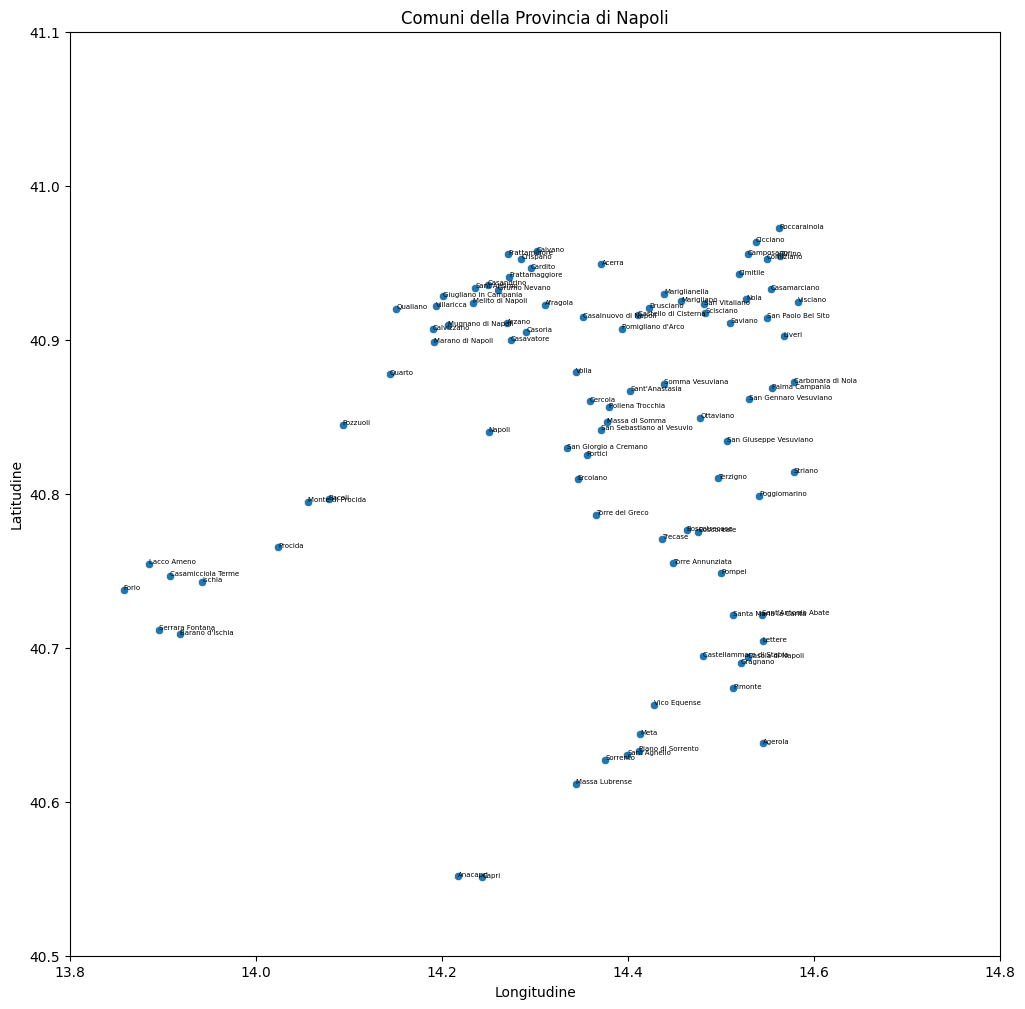

In [5]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.scatterplot(data=Napoli, y='Latitudine', x='Longitudine', ax=ax)

ax.set_xlim(13.8, 14.8) 
ax.set_ylim(40.5, 41.1)

for _, row in Napoli.iterrows():
    ax.text(row["Longitudine"], row["Latitudine"], row["COMUNE"], fontsize=5)

plt.title("Comuni della Provincia di Napoli")
plt.savefig('mappa_napoli.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # raggio terrestre in metri

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c


lat = Napoli["Latitudine"].values
lon = Napoli["Longitudine"].values
n = len(lat)

dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = haversine(lat[i], lon[i], lat[j], lon[j])

distances = pd.DataFrame(dist_matrix, index=Napoli["COMUNE"], columns=Napoli["COMUNE"])


In [ ]:
nomi_5 = Napoli['COMUNE'].iloc[:5].tolist()
matrice_5x5 = distances.iloc[:5, :5] / 1000 
df_estratto = pd.DataFrame(matrice_5x5.values, index=nomi_5, columns=nomi_5).round(2)

styled_table = df_estratto.style.background_gradient(cmap='Blues').format("{:.2f} km")
display(styled_table)

print("\n--- COPIA IL CODICE QUI SOTTO PER OVERLEAF ---")
print(df_estratto.to_latex())

plt.figure(figsize=(10, 8))
sns.heatmap(df_estratto, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'km'})
plt.title("Mappa di Calore delle Distanze (km)")
plt.savefig('matrice_calore.png', dpi=300, bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')

tabella_img = ax.table(cellText=df_estratto.values, 
                       colLabels=df_estratto.columns, 
                       rowLabels=df_estratto.index,
                       loc='center', 
                       cellLoc='center')

tabella_img.auto_set_font_size(False)
tabella_img.set_fontsize(12)
tabella_img.scale(1.2, 2.5)

for (row, col), cell in tabella_img.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#2c3e50')
    else:
        cell.set_facecolor('#ecf0f1')

plt.savefig('matrice_distanze.png', dpi=300, bbox_inches='tight')
plt.close()


,Acerra,Afragola,Agerola,Anacapri,Arzano
Acerra,0.00 km,5.88 km,37.53 km,46.07 km,9.58 km
Afragola,5.88 km,0.00 km,37.31 km,42.03 km,3.72 km
Agerola,37.53 km,37.31 km,0.00 km,29.33 km,38.18 km
Anacapri,46.07 km,42.03 km,29.33 km,0.00 km,40.17 km
Arzano,9.58 km,3.72 km,38.18 km,40.17 km,0.00 km



--- COPIA IL CODICE QUI SOTTO PER OVERLEAF ---
\begin{tabular}{lrrrrr}
\toprule
 & Acerra & Afragola & Agerola & Anacapri & Arzano \\
\midrule
Acerra & 0.000000 & 5.880000 & 37.530000 & 46.070000 & 9.580000 \\
Afragola & 5.880000 & 0.000000 & 37.310000 & 42.030000 & 3.720000 \\
Agerola & 37.530000 & 37.310000 & 0.000000 & 29.330000 & 38.180000 \\
Anacapri & 46.070000 & 42.030000 & 29.330000 & 0.000000 & 40.170000 \\
Arzano & 9.580000 & 3.720000 & 38.180000 & 40.170000 & 0.000000 \\
\bottomrule
\end{tabular}



In [7]:
bins = [-1, 0, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 65000]
labels = ["0","1", "2", "3", "4", "5", "6", "7", "8"]

dist_levels = pd.DataFrame(
    pd.cut(distances.values.flatten(), bins=bins, labels=labels)
    .reshape(distances.shape),
    index=distances.index,
    columns=distances.columns
)


In [8]:
Napoli['Domanda'] = Napoli['FAM21'] * 2 # media ordini in Italia

/var/folders/nf/0yfd5sbj61zggffg8w3y68th0000gn/T/ipykernel_66377/3894627491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Napoli['Domanda'] = Napoli['FAM21'] * 2 # media ordini in Italia


In [9]:
percentuali_di_compliance = {
    "0": 1,
    "1": 0.9,
    "2": 0.8,
    "3": 0.7,
    "4": 0.6,
    "5": 0.5,
    "6": 0.4,
    "7": 0.3,
    "8": 0.1
}

sconto da applicare sul ricavo unitario per utilizzo del servizio

In [10]:
sconto = {
    "0": 0,
    "1": 0.05,
    "2": 0.05,
    "3": 0.10,
    "4": 0.10,
    "5": 0.15,
    "6": 0.15,
    "7": 0.20,
    "8": 0.20
}

In [11]:
ricavi = np.array([3, 3.25, 3.5, 3.75, 4])

domanda = Napoli['Domanda'].values.reshape(-1, 1)

# prodotto vettoriale: ogni colonna è domanda * ricavo
matrice_ricavi = domanda * ricavi


In [12]:
costi_fissi_e_operativi = 22500

In [13]:
matrice_ricavi

array([[ 124152. ,  134498. ,  144844. ,  155190. ,  165536. ],
       [ 132132. ,  143143. ,  154154. ,  165165. ,  176176. ],
       [  18414. ,   19948.5,   21483. ,   23017.5,   24552. ],
       [  16104. ,   17446. ,   18788. ,   20130. ,   21472. ],
       [  69630. ,   75432.5,   81235. ,   87037.5,   92840. ],
       [  60510. ,   65552.5,   70595. ,   75637.5,   80680. ],
       [  25566. ,   27696.5,   29827. ,   31957.5,   34088. ],
       [  57150. ,   61912.5,   66675. ,   71437.5,   76200. ],
       [  23094. ,   25018.5,   26943. ,   28867.5,   30792. ],
       [  33444. ,   36231. ,   39018. ,   41805. ,   44592. ],
       [  75234. ,   81503.5,   87773. ,   94042.5,  100312. ],
       [  26544. ,   28756. ,   30968. ,   33180. ,   35392. ],
       [  11688. ,   12662. ,   13636. ,   14610. ,   15584. ],
       [  18060. ,   19565. ,   21070. ,   22575. ,   24080. ],
       [   5316. ,    5759. ,    6202. ,    6645. ,    7088. ],
       [  45798. ,   49614.5,   53431. ,